In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
from google.colab import files

uploaded = files.upload()

Saving analysis3_daily_actual.csv to analysis3_daily_actual.csv
Saving analysis3_daily_plan.csv to analysis3_daily_plan.csv


In [3]:
plan = pd.read_csv("analysis3_daily_plan.csv")
actual = pd.read_csv("analysis3_daily_actual.csv")

print(plan.shape)
print(actual.shape)

plan.head()

(64, 16)
(21, 4)


,userId,date,todoId,plannedMinutes,capMinutes,totalPlannedMinutes,spi,eacDate,riskLevel,idealProgress,actualProgress,deadline,deadlineDate,statsUpdatedAt,statsUpdatedDate,planUpdatedAt
0,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-09,OBRscVWDrP6T2dgGwzRM,135,300,300,0.00,NaN,late,1.00,0.38,2025-12-09T09:00:00.000Z,2025-12-09,2025-12-16T05:24:42.160Z,2025-12-16,2025-12-08T20:36:47.531Z
1,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-09,PMlKDTosFFAwOZY964VQ,81,300,300,0.00,NaN,warn,0.89,0.20,2025-12-16T16:00:00.000Z,2025-12-17,2025-12-14T17:52:47.448Z,2025-12-15,2025-12-08T20:36:47.531Z
2,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-09,yFII5G1f8Yf47CTrPlWC,84,300,300,0.14,2026-11-18,late,0.59,0.37,2026-01-31T09:00:00.000Z,2026-01-31,2025-12-21T22:03:11.635Z,2025-12-22,2025-12-08T20:36:47.531Z
3,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-10,9C4W0XuzGdszlPaCuvAA,7,300,87,0.00,248437-07-12,late,0.08,0.00,2025-12-05T09:00:00.000Z,2025-12-05,2025-11-24T06:56:33.110Z,2025-11-24,2025-12-09T16:35:05.953Z
4,DgApBqtxpeVE5G5MnIVw9ThpyN93,2025-12-10,fqZOw2HYGDo7HAX4kWfu,63,300,87,0.32,2025-12-09,late,1.00,0.22,2025-12-05T09:00:00.000Z,2025-12-05,2025-12-05T10:47:00.312Z,2025-12-05,2025-12-09T16:35:05.953Z


In [4]:
df = plan.merge(
    actual,
    on=["userId", "date", "todoId"],
    how="left"
)

df["actualMinutes"] = df["actualMinutes"].fillna(0)

In [5]:
df["adherence"] = df["actualMinutes"] / df["plannedMinutes"]
df.loc[df["plannedMinutes"] <= 0, "adherence"] = np.nan

In [6]:
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["todoId", "date"])

In [7]:
df["spi_next"] = df.groupby("todoId")["spi"].shift(-1)
df["delta_spi"] = df["spi_next"] - df["spi"]

In [8]:
df["eacDate"] = pd.to_datetime(df["eacDate"], errors="coerce")
df["eac_next"] = df.groupby("todoId")["eacDate"].shift(-1)

df["eac_slip"] = df["eac_next"] > df["eacDate"]

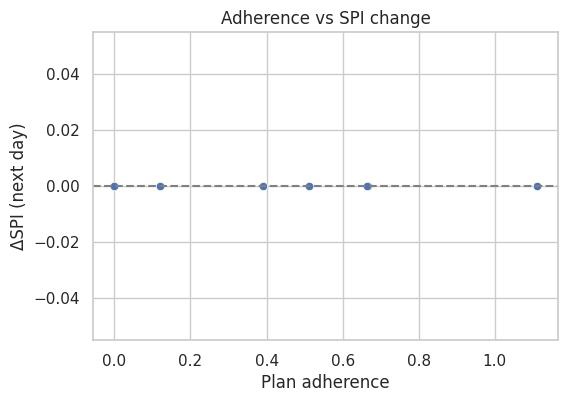

In [9]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="adherence", y="delta_spi")
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Plan adherence")
plt.ylabel("ΔSPI (next day)")
plt.title("Adherence vs SPI change")
plt.show()

/tmp/ipython-input-4249715493.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eac_rate = df.groupby("adherence_group")["eac_slip"].mean()


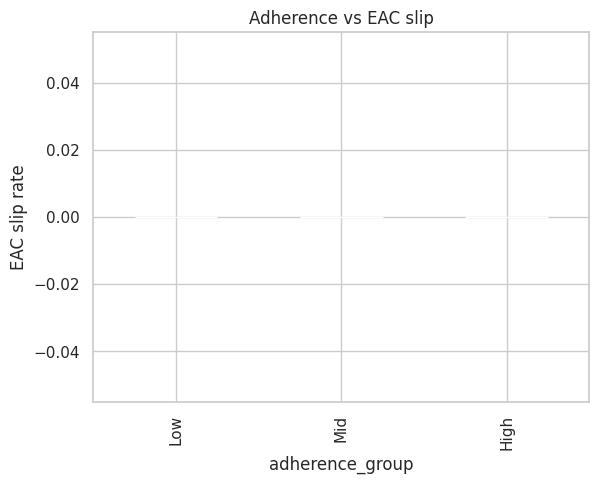

In [10]:
df["adherence_group"] = pd.cut(
    df["adherence"],
    bins=[0, 0.5, 0.8, 1.0],
    labels=["Low", "Mid", "High"]
)

eac_rate = df.groupby("adherence_group")["eac_slip"].mean()

eac_rate.plot(kind="bar")
plt.ylabel("EAC slip rate")
plt.title("Adherence vs EAC slip")
plt.show()